# Demo Script for Milestone 10.15

## 0 Prepare task

### 0.1 prepare planning scene

#### Run camera server on the camera computer (192.168.0.10, use vnc viewer)
```bash
python stream_server.py --ip='192.168.0.10'
```
#### Run shared detector on bash
```bash
python3 /home/jhkim/Projects/rnb-planning/src/scripts/milestone_202110/utils/shared_detector.py
```

### Check IP request ip setting from mobile udp client (robot-side)

In [1]:
import os
import sys
sys.path.append(os.path.join(os.path.join(os.environ["RNB_PLANNING_DIR"], 'src')))
sys.path.append(os.path.join(os.environ["RNB_PLANNING_DIR"], 'src/scripts/milestone_202110'))

from pkg.global_config import RNB_PLANNING_DIR
from demo_utils.kiro_udp_send import start_mobile_udp_thread, send_pose_wait, get_xyzw_cur, get_reach_state
from pkg.utils.utils import *    
from pkg.utils.rotation_utils import *
from pkg.controller.combined_robot import *
from pkg.project_config import *
from demo_utils.streaming import *
from demo_utils.detect_table import *
from demo_utils.area_select import *
from pkg.detector.aruco.marker_config import get_aruco_map
aruco_map = get_aruco_map()


CONNECT_CAM = True
ENABLE_DETECT = True
# DETECT_MARKER = True
CONNECT_INDY = True
CONNECT_MOBILE = True 
VISUALIZE = True

# Tool dimensions
TOOL_DIM = [0.32, 0.08]
TOOL_OFFSET = 0.01
MARGIN = 0
TRACK_THICKNESS = 0.001

INDY_BASE_OFFSET = (0.172,0,0.439)
TOOL_NAME = "brush_face"
WALL_THICKNESS = 0.01
CLEARANCE = 0.001

ip_cur = "192.168.0.8"# get_ip_address()
MOBILE_IP = "192.168.0.102"
INDY_IP = "192.168.0.3"
CAM_HOST = '192.168.0.10'

print("Current PC IP: {}".format(ip_cur))
print("Mobile ROB IP: {}".format(MOBILE_IP))
print("CAM SERVER IP: {}".format(CAM_HOST))

from pkg.geometry.builder.scene_builder import SceneBuilder
from demo_utils.environment import *

from utils.streaming import *
from utils.detection_util import *

mobile_config = RobotConfig(0, RobotType.kmb, ((0,0,0), (0,0,0)),
                MOBILE_IP)
robot_config = RobotConfig(1, RobotType.indy7, (INDY_BASE_OFFSET, (0,0,0)),
                INDY_IP, root_on="kmb0_platform", 
                           specs={"no_sdk":True})
MOBILE_NAME = mobile_config.get_indexed_name()
ROBOT_NAME = robot_config.get_indexed_name()
crob = CombinedRobot(robots_on_scene=[mobile_config, robot_config]
              , connection_list=[False, CONNECT_INDY])

s_builder = SceneBuilder(None)
gscene = s_builder.create_gscene(crob)

gtems = s_builder.add_robot_geometries(color=(0,1,0,0.5), display=True, collision=True)
gscene.set_workspace_boundary(-3, 7, -5, 5, -CLEARANCE, 3, thickness=WALL_THICKNESS)


from pkg.planning.scene import PlanningScene
pscene = PlanningScene(gscene, combined_robot=crob)

ROBOT_BASE = pscene.robot_chain_dict[ROBOT_NAME]['link_names'][0]
TIP_LINK = pscene.robot_chain_dict[ROBOT_NAME]["tip_link"]
MOBILE_BASE = pscene.robot_chain_dict[MOBILE_NAME]["tip_link"]
HOLD_LINK = MOBILE_BASE

viewpoint = add_cam(gscene, tool_link=TIP_LINK)
# add_indy_tool_kiro(gscene, tool_link=TIP_LINK, face_name=TOOL_NAME, zoff=TOOL_OFFSET)

HOME_POSE = -crob.home_pose
HOME_DICT = list2dict(HOME_POSE, gscene.joint_names)

from pkg.planning.pipeline import PlanningPipeline
ppline = PlanningPipeline(pscene)

# Set planner
from pkg.planning.motion.moveit.moveit_planner import MoveitPlanner
from pkg.planning.filtering.grasp_filter import GraspChecker
mplan = MoveitPlanner(pscene, enable_dual=False, incremental_constraint_motion=True)
mplan.motion_filters = [GraspChecker(pscene)]
mplan.update_gscene()
gcheck = GraspChecker(pscene)
mplan.motion_filters = [gcheck]

from pkg.planning.task.rrt import TaskRRT
tplan = TaskRRT(pscene)
tplan.prepare()
ppline.set_motion_planner(mplan)
ppline.set_task_planner(tplan)

from pkg.ui.ui_broker import *

# start UI
ui_broker = UIBroker.instance()
ui_broker.initialize(ppline, s_builder)
ui_broker.start_server()

ui_broker.set_tables()

add_kiro_indytool_down(gscene, zoff=TOOL_OFFSET, tool_link=TIP_LINK, face_name=TOOL_NAME)

# Register binders
from pkg.planning.constraint.constraint_actor import VacuumTool, Gripper2Tool, PlacePlane, SweepFramer, WayFramer
brush_face = pscene.create_binder(bname=TOOL_NAME, gname=TOOL_NAME, _type=SweepFramer, 
                                  point=(-gscene.NAME_DICT['brush_face'].dims[0]/2-CLEARANCE,0,0), 
                                  rpy=(0,np.pi/2*1,0))

# waypoint
WP_DIMS = (0.6,0.4,WALL_THICKNESS)
gscene.create_safe(gtype=GEOTYPE.BOX, name="wayframer", link_name=HOLD_LINK,
                   dims=WP_DIMS, center=(0,0,WP_DIMS[2]/2), rpy=(0,0,0), color=(1, 0, 0, 0.5), display=True,
                   collision=False, fixed=True)
wayframer = pscene.create_binder(bname="wayframer", gname="wayframer", _type=WayFramer, 
                                 point=(0,0,-WP_DIMS[2]/2-CLEARANCE), rpy=(0,0,0))

indy = crob.robot_dict["indy1"]

if CONNECT_MOBILE:
    sock_mobile, server_thread = start_mobile_udp_thread(recv_ip=ip_cur)
    time.sleep(1)

Current PC IP: 192.168.0.8
Mobile ROB IP: 192.168.0.102
CAM SERVER IP: 192.168.0.10
connection command:
kmb0: False
indy1: True
Connect: Server IP (192.168.0.3)
Please create a subscriber to the marker
publication OK
published: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Please create a subscriber to the marker
Dash is running on http://0.0.0.0:8050/

 * Serving Flask app "pkg.ui.dash_launcher" (lazy loading)
[MOBILE ROBOT] bind: ('192.168.0.8', 50306)
 * Environment: production
[MOBILE ROBOT] Start UDP THREAD
   Use a production WSGI server instead.
 * Debug mode: off


### 0.2 Wait task start queue

## 1. Detect scene

### 1.1 Detect bed

#### 1.1.1 Move to bed-seek pose 

In [2]:
VIEW_POSE = np.deg2rad([  0., 50.,  -70.,  -0.,  -90., 0])
VIEW_LOC = [0,]*6
VIEW_POSE_EXT = np.array(VIEW_LOC + list(VIEW_POSE))
if CONNECT_INDY:
    with indy:
        indy.joint_move_to(np.rad2deg(VIEW_POSE))
        time.sleep(0.5)
        indy.wait_for_move_finish()
        Qcur = np.deg2rad(indy.get_joint_pos())
else:
    Qcur = VIEW_POSE
gscene.show_pose(VIEW_POSE_EXT)

Connect: Server IP (192.168.0.3)
Move finished!


* **[TODO] rotate until bed is detected**

In [3]:
if ENABLE_DETECT:
    attacth_to_server()

In [4]:
# CAM_HOST = '192.168.0.40'
if CONNECT_CAM:
    # rdict = send_recv_demo_cam({1:1}, host=CAM_HOST)
    rdict = stream_capture_image(ImageType.FirstView, obj_type="bed", host=CAM_HOST)
    cam_intrins, d_scale = [rdict[key] for key in ["intrins", "depth_scale"]]
    set_cam_params(cam_intrins, d_scale)
    cam_width, cam_height, cam_fx, cam_fy, cam_ppx, cam_ppy = cam_intrins
    __d_scale = d_scale
    bed_color_path = SAVE_DIR + '/bed.jpg'
    bed_depth_path = SAVE_DIR + '/bed.png'
else:
#     cam_intrins = [1280, 720, 899.05322265625,  899.21044921875, 654.8836669921875, 352.9295654296875]
#     d_scale = 0.0002500000118743628
    cam_intrins = [1280, 720, 909.957763671875,  909.90283203125, 638.3824462890625, 380.0085144042969]
    d_scale = 1 / 3999.999810010204
    set_cam_params(cam_intrins, d_scale)
    cam_width, cam_height, cam_fx, cam_fy, cam_ppx, cam_ppy = cam_intrins
    __d_scale = d_scale
    bed_color_path = SAVE_DIR + '/bed.jpg'
    bed_depth_path = SAVE_DIR + '/bed.png'
#     bed_color_path = EXP_IMG_DIR + '/bed.jpg'
#     bed_depth_path = EXP_IMG_DIR + '/bed.png'
#     bed_color_path = EXP_IMG_DIR + '/513.jpg'
#     bed_depth_path = EXP_IMG_DIR + '/top_table_0024.png'

# Read color, depth image file, keep 16bit information
color_img_read = cv2.imread(bed_color_path, flags=cv2.IMREAD_UNCHANGED)
depth_img_read = cv2.imread(bed_depth_path, flags=cv2.IMREAD_UNCHANGED)

# Output of inference(mask for detected table)
mask_out = detect_from_server(color_img_read)

# If bed is not detected, then pass below detection part
test = np.empty((720,1280), dtype=bool)
test[:,:] = False

In [5]:
while np.array_equal(mask_out, test):
    if CONNECT_INDY:
        with indy:
            Qnow = indy.get_joint_pos()
            Qto = np.add(Qnow, [10,0,0,0,0,0])
            Qto[0] = (Qto[0]+np.pi/2)%np.pi-np.pi/2
            indy.joint_move_to(Qto)
            indy.wait_motion()
    
    
    # Take a picture again after rotate
    time.sleep(1)
    rdict = stream_capture_image(ImageType.FirstView, obj_type="bed", host=CAM_HOST)
    
    # Read color, depth image file, keep 16bit information
    color_img_read = cv2.imread(bed_color_path, flags=cv2.IMREAD_UNCHANGED)
    depth_img_read = cv2.imread(bed_depth_path, flags=cv2.IMREAD_UNCHANGED)
    
    # Output of inference(mask for detected table)
    mask_out = detect_from_server(color_img_read)

:: Load two point clouds and disturb initial pose.
:: Downsample with a voxel size 0.038.
:: Estimate normal with search radius 0.076.
:: Compute FPFH feature with search radius 0.228.
:: Downsample with a voxel size 0.038.
:: Estimate normal with search radius 0.076.
:: Compute FPFH feature with search radius 0.228.
Apply point-to-point ICP
registration::RegistrationResult with fitness=6.540223e-01, inlier_rmse=6.956400e-02, and correspondence_set size of 27414
Access transformation to get result.
Transformation is:
[[ 0.95312787 -0.12570168  0.27522053 -0.19237664]
 [-0.22281048 -0.9069956   0.35737162 -0.39944749]
 [ 0.2047016  -0.40194287 -0.89249044  5.02342292]
 [ 0.          0.          0.          1.        ]]
:: Load two point clouds and disturb initial pose.
:: Downsample with a voxel size 0.038.
:: Estimate normal with search radius 0.076.
:: Compute FPFH feature with search radius 0.228.
:: Downsample with a voxel size 0.038.
:: Estimate normal with search radius 0.076.
:: 

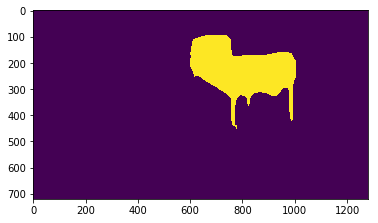

In [6]:
T_bc = viewpoint.get_tf(VIEW_POSE_EXT)
# Try ICP1
if not np.array_equal(mask_out, test):
    plt.imshow(mask_out)
    
    # Crop masking part
    vis_mask = (mask_out * 255).astype('uint8')
    color_instance = cv2.bitwise_and(color_img_read, color_img_read, mask=vis_mask).astype(np.uint16)
    depth_instance = cv2.bitwise_and(depth_img_read, depth_img_read, mask=vis_mask).astype(np.uint16)
    cv2.imwrite(CROP_DIR + '/bed_crop.jpg', color_instance)
    cv2.imwrite(CROP_DIR + '/bed_crop.png', depth_instance)
    
    ICP_result_bed1, fitness1 = process_bed_detection_front(T_bc, visualize=False)
    
    # Try ICP2
if not np.array_equal(mask_out, test):
    plt.imshow(mask_out)
    
    # Crop masking part
    vis_mask = (mask_out * 255).astype('uint8')
    color_instance = cv2.bitwise_and(color_img_read, color_img_read, mask=vis_mask).astype(np.uint16)
    depth_instance = cv2.bitwise_and(depth_img_read, depth_img_read, mask=vis_mask).astype(np.uint16)
    cv2.imwrite(CROP_DIR + '/bed_crop.jpg', color_instance)
    cv2.imwrite(CROP_DIR + '/bed_crop.png', depth_instance)
    
    ICP_result_bed2, fitness2 = process_bed_detection(visualize=False)

#### 1.1.2  detect bed and add to the scene

In [7]:
# Better result is adopted
if fitness1 > fitness2:
    ICP_result_bed = ICP_result_bed1
else:
    ICP_result_bed = ICP_result_bed2        

    
# Coorinate offeset
T_toff_bed = np.identity(4)
T_toff_bed[:3,:3] = np.array([[0,1,0],[0,0,1],[1,0,0]])
T_toff_bed[:3,3] = np.array([0.455,0,1.02])

T_co_bed = np.matmul(ICP_result_bed, T_toff_bed)
T_bc = viewpoint.get_tf(list2dict(VIEW_POSE_EXT, gscene.joint_names))
T_bo_bed = np.matmul(T_bc, T_co_bed)

bed_center = T_bo_bed[:3,3]
bed_rpy = Rot2rpy(T_bo_bed[:3,:3])
# bed_center = (2,0,0)
# bed_rpy = (0,0,np.pi/2)
COLOR_BED_COL = (0,1,0,0.3)

bed_mat = add_bed(gscene, bed_center, bed_rpy, COLOR_BED_COL)

In [8]:
bed_vis = gscene.NAME_DICT["bed_vis"]
# T_revis = np.identity(4)
# T_revis[:3,:3] = Rot_axis(3, Rot2axis(bed_vis.get_tf(VIEW_POSE_EXT)[:3,:3],3))
# bed_rpy = Rot2rpy(Rot_axis(3, Rot2axis(bed_vis.get_tf(VIEW_POSE_EXT)[:3,:3],3)
T_bo_new = align_z(T_bo_bed)
bed_rpy = Rot2rpy(T_bo_new[:3,:3])

# adjust
bed_center[2]=0
if Rot_rpy(bed_rpy)[0,0] > 0:
    bed_rpy[2] += np.pi

move_bed(gscene, bed_center, bed_rpy)

### 1.2 Detect Closet

#### 1.2.1  move to closet side

In [9]:
bed_vis = gscene.NAME_DICT["bed_vis"]
T_bo = bed_vis.get_tf(list2dict(VIEW_POSE_EXT, gscene.joint_names))

In [10]:
if CONNECT_CAM:
    color_path = SAVE_DIR + '/bed.jpg'
    depth_path = SAVE_DIR + '/bed.png'
else:
    color_path = EXP_IMG_DIR + '/bed.jpg'
    depth_path = EXP_IMG_DIR + '/bed.png'

if ENABLE_DETECT:
    # Determine the location of closet
    CLOSET_LOCATION = check_location_top_table(color_path, depth_path, T_bc, T_bo, bed_dims=bed_mat.dims, 
                                               visualize=False)
    print("CLOSET on {}".format(CLOSET_LOCATION))

    T_bm_from = wayframer.get_tf_handle(list2dict(VIEW_POSE_EXT, gscene.joint_names))
    T_bs = bed_mat.get_tf(VIEW_POSE_EXT)

    if CLOSET_LOCATION == "LEFT":
        T_sm = SE3(Rot_axis(3, np.pi), [1.5, -1.33, 0])
    elif CLOSET_LOCATION == "RIGHT":       
        T_sm = SE3(Rot_axis(3, np.pi), [1.5, 1.33, 0])

    T_bm = np.matmul(T_bs, T_sm)

    x,y = T_bm[:2,3]
    theta = Rot2axis(T_bm[:3,:3], 3)
else:
    T_bs = bed_mat.get_tf(VIEW_POSE_EXT)
    T_sm = SE3(Rot_axis(3, np.pi), [1.5, -1.33, 0])
    T_bm = np.matmul(T_bs, T_sm)

    x,y = T_bm[:2,3]
    theta = Rot2axis(T_bm[:3,:3], 3)
    
VIEW_MOVED_EXT = np.add(VIEW_POSE_EXT, [x,y,theta]+[0]*9) 
gscene.show_pose(VIEW_MOVED_EXT)

CLOSET on LEFT


#### move camera up

In [11]:
VIEW_MOVED = np.deg2rad([  0., 50.,  -70.,  -0.,  -70., 0])
if CONNECT_INDY:
    with indy:
        indy.joint_move_to(np.rad2deg(VIEW_MOVED))
    
VIEW_MOVED_EXT[crob.idx_dict[ROBOT_NAME]] = VIEW_MOVED

Connect: Server IP (192.168.0.3)


In [12]:
if CONNECT_MOBILE:
    VIEW_MOVED_EXT = move_mobile_update_state(sock_mobile, MOBILE_IP, wayframer, VIEW_POSE_EXT, VIEW_MOVED_EXT, 
                                              D_APPROACH=0)
gscene.show_pose(VIEW_MOVED_EXT)

move to VIEW_MOVED_EXT: [ 2.42   0.164  0.278  0.     0.     0.     0.     0.873 -1.222 -0.
 -1.222  0.   ]
curre  xyzw: [ 0.8   1.68 -0.15  0.99]
ready  xyzw: [ 3.16  1.13 -0.01  1.  ]
target xyzw: [ 3.16  1.13 -0.01  1.  ]
move to: [ 3.16  1.13 -0.01  1.  ]
(3.1623524551049407, 1.1297556586155082, -0.00961701195696705, 0.9999537554712316, 0)
move to: [ 3.16  1.13 -0.01  1.  ]
(3.1623524551049407, 1.1297556586155082, -0.00961701195696705, 0.9999537554712316, 0)
(3.1623524551049407, 1.1297556586155082, -0.00961701195696705, 0.9999537554712316, 0)
(3.1623524551049407, 1.1297556586155082, -0.00961701195696705, 0.9999537554712316, 0)
stop at: [3.13 1.16 0.01 1.  ]
ended in VIEW_MOVED_EXT: [ 2.377  0.178  0.314  0.     0.     0.     0.     0.873 -1.222 -0.
 -1.222  0.   ]


#### 1.2.2  detect and add closet

In [13]:
if ENABLE_DETECT:
    if CONNECT_CAM:
        rdict = stream_capture_image(ImageType.FirstView, obj_type="closet", host=CAM_HOST)
        closet_color_path = SAVE_DIR + '/top_table.jpg'
        closet_depth_path = SAVE_DIR + '/top_table.png'
    else:
        closet_color_path = EXP_IMG_DIR + '/top_table_0024.jpg'
        closet_depth_path = EXP_IMG_DIR + '/top_table_0024.png'

    if CONNECT_CAM:
        Qdict_scan = list2dict(VIEW_MOVED_EXT, gscene.joint_names)
    else:
        VIEW_POSE_MID = np.deg2rad([  0., 50.,  -70.,  -0.,  -75., 180])
        VIEW_MOVED_EXT[6:] = VIEW_POSE_MID
        Qdict_scan = list2dict(VIEW_MOVED_EXT, gscene.joint_names)
    T_bc = viewpoint.get_tf(Qdict_scan)
    T_bs = bed_vis.get_tf(Qdict_scan)
    T_sc = np.matmul(SE3_inv(T_bs), T_bc)

    ICP_result_top_table = process_top_table_detection(closet_color_path, closet_depth_path, T_sc=T_sc,
                                                       bed_dims=bed_mat.dims, z_ceiling = 2.3,
                                                       initial_offset=[0.3,1.1,0.6], floor_margin=0.1,
                                                       visualize=False)

    T_toff_top_table = np.identity(4)
    T_toff_top_table[:3,:3] = np.array([[1,0,0],[0,0,1],[0,-1,0]])
    T_toff_top_table[:3,3] = np.array([0.3,0,0.2725])

    T_co = np.matmul(ICP_result_top_table, T_toff_top_table)
    T_bc = viewpoint.get_tf(list2dict(VIEW_MOVED_EXT, gscene.joint_names))
    T_bo = np.matmul(T_bc, T_co)
    T_bo[:3,:3] = Rot_axis(3, Rot2axis(T_bo[:3,:3], 3))
    T_bo[2,3] = 0
else:
    T_bo = T_xyzrpy((np.matmul(Rot_rpy(bed_rpy), (-0.75,-1.5,0))+bed_center, 
                     bed_rpy))

closet_leftup, closet_rightup, closet_down = add_closet(
    gscene, closet_center=T_bo[:3,3], closet_rpy=Rot2rpy(T_bo[:3,:3]), 
    COLOR_CLOSET_COL=(0,1,0,0.3))

:: Load two point clouds and disturb initial pose.
:: Downsample with a voxel size 0.030.
:: Estimate normal with search radius 0.060.
:: Compute FPFH feature with search radius 0.180.
:: Downsample with a voxel size 0.030.
:: Estimate normal with search radius 0.060.
:: Compute FPFH feature with search radius 0.180.
Apply point-to-point ICP
registration::RegistrationResult with fitness=1.185011e-01, inlier_rmse=1.923152e-02, and correspondence_set size of 955
Access transformation to get result.
Transformation is:
[[-0.01395567 -0.04025547 -0.99909196  0.50984379]
 [ 0.02256205 -0.99894754  0.03993449  1.200697  ]
 [-0.99964803 -0.02198425  0.01484923  2.67693717]
 [ 0.          0.          0.          1.        ]]


### 1.3 set checker

In [14]:
wp_task, wp_hdl = add_waypoint_task(pscene, "waypoint", WP_DIMS, (0,0,0), (0,0,0), 
                                    parent="floor_ws", color=(0, 0, 1, 0.5))
ccheck = CachedCollisionCheck(gcheck, wp_task, wp_hdl, wayframer)


## 2. Closet cleaning

### 2.1. Make closet cleaning plan

In [15]:
from pkg.planning.constraint.constraint_common import *
from pkg.planning.constraint.constraint_actor import *
from pkg.planning.constraint.constraint_subject import *
from pkg.utils.code_scraps import get_look_motion

In [16]:
Q_CUR = VIEW_MOVED_EXT
HOME_POSE_SWEEP = np.copy(Q_CUR)
# HOME_POSE_SWEEP[6:] = 0
crob.home_pose = HOME_POSE_SWEEP
crob.home_dict = list2dict(crob.home_pose, gscene.joint_names)
floor_ws = gscene.NAME_DICT["floor_ws"]    


wp_task, wp_hdl = add_waypoint_task(pscene, "waypoint", WP_DIMS, (0,0,0), (0,0,0), 
                                    parent="floor_ws", color=(0, 0, 1, 0.5))

add_kiro_indytool_down(gscene, zoff=TOOL_OFFSET, tool_link=TIP_LINK, face_name=TOOL_NAME)
brush_face = pscene.create_binder(bname=TOOL_NAME, gname=TOOL_NAME, _type=SweepFramer, 
                                  point=(0,0,-gscene.NAME_DICT['brush_face'].dims[2]/2-CLEARANCE), 
                                  rpy=(0,0,0))

In [17]:
ccheck.clear()
div_base_dict, Tsm_keys, surface_div_centers, div_num, (ax_step, ax_swp, ax_pln) = \
                        get_division_dict(closet_leftup, brush_face, robot_config, 
                                          plane_val=None, tip_dir="up", TOOL_DIM=TOOL_DIM, 
                                          ccheck=ccheck, resolution=0.02)

HOME_POSE_MOVE = np.copy(Q_CUR[6:])
test_fun_cl = TestBaseDivFunc(ppline, floor_ws, closet_leftup, WP_DIMS, TOOL_DIM, crob.home_dict, tool_dir=1)
test_fun_cl.clear()

idx_bases, idc_divs, covered_all, snode_schedule_list = select_max_cover_bases(
    div_base_dict, Tsm_keys, surface_div_centers, div_num, ax_step, 
    test_fun=test_fun_cl)
snode_schedule_list_leftup, idx_bases, idc_divs, scene_args_list_leftup, scene_kwargs_list_leftup = refine_order_plan(
    ppline, snode_schedule_list, idx_bases, idc_divs, Q_CUR, 
    floor_ws, wayframer, closet_leftup, Tsm_keys, surface_div_centers,  
    WP_DIMS, TOOL_DIM, ROBOT_NAME, MOBILE_NAME, HOME_POSE_MOVE)
test_fun_cl.clear()
Q_CUR = snode_schedule_list_leftup[-1][-1].state.Q

terminate_on_first is deprecated. Use max_solution_count=1
Use 36/36 agents
======================= terminated 27: max iteration time reached (1635130406/1635130403.0 s) ===============================
======================= terminated 32: max iteration time reached (1635130406/1635130403.0 s) ===============================
======================= terminated 33: max iteration time reached (1635130406/1635130403.0 s) ===============================
======================= terminated 17: max iteration time reached (1635130406/1635130403.0 s) ===============================
======================= terminated 1: max iteration time reached (1635130406/1635130403.0 s) ===============================
======================= terminated 8: max iteration time reached (1635130406/1635130403.0 s) ===============================
terminate_on_first is deprecated. Use max_solution_count=1
Use 36/36 agents
Goal reached
Goal reached
======================= terminated 0: required answers acquired ====

======================= terminated 32: required answers acquired from other agent ===============================
======================= terminated 33: required answers acquired from other agent ===============================
======================= terminated 20: required answers acquired from other agent ===============================
======================= terminated 34: required answers acquired from other agent ===============================
======================= terminated 35: required answers acquired from other agent ===============================
======================= terminated 5: required answers acquired from other agent ===============================
======================= terminated 4: required answers acquired from other agent ===============================
======================= terminated 10: required answers acquired from other agent ===============================
======================= terminated 13: required answers acquired from other agent ========

======================= terminated 35: required answers acquired from other agent ===============================
======================= terminated 11: required answers acquired ===============================
Goal reached
======================= terminated 12: required answers acquired ===============================
Goal reached
======================= terminated 14: required answers acquired ===============================
======================= terminated 29: required answers acquired from other agent ===============================
======================= terminated 6: required answers acquired from other agent ===============================
======================= terminated 18: required answers acquired from other agent ===============================
======================= terminated 15: required answers acquired from other agent ===============================
======================= terminated 24: required answers acquired from other agent ===============================


======================= terminated 19: required answers acquired from other agent ===============================
======================= terminated 11: required answers acquired from other agent ===============================
======================= terminated 20: required answers acquired from other agent ===============================
======================= terminated 28: required answers acquired from other agent ===============================
======================= terminated 29: required answers acquired from other agent ===============================
terminate_on_first is deprecated. Use max_solution_count=1
Use 36/36 agents
Goal reached
Goal reached
======================= terminated 5: required answers acquired ===============================
======================= terminated 0: required answers acquired from other agent ===============================
======================= terminated 33: required answers acquired from other agent ===============================
=====

In [18]:
ccheck.clear()
div_base_dict, Tsm_keys, surface_div_centers, div_num, (ax_step, ax_swp, ax_pln) = \
                        get_division_dict(closet_rightup, brush_face, robot_config, 
                                          plane_val=None, tip_dir="up", TOOL_DIM=TOOL_DIM, 
                                          ccheck=ccheck, resolution=0.02)

HOME_POSE_MOVE = np.copy(Q_CUR[6:])
test_fun_cl = TestBaseDivFunc(ppline, floor_ws, closet_rightup, WP_DIMS, TOOL_DIM, crob.home_dict, tool_dir=1)
test_fun_cl.clear()

idx_bases, idc_divs, covered_all, snode_schedule_list = select_max_cover_bases(
    div_base_dict, Tsm_keys, surface_div_centers, div_num, ax_step, 
    test_fun=test_fun_cl)
snode_schedule_list_rightup, idx_bases, idc_divs, scene_args_list_rightup, scene_kwargs_list_rightup = refine_order_plan(
    ppline, snode_schedule_list, idx_bases, idc_divs, Q_CUR, 
    floor_ws, wayframer, closet_rightup, Tsm_keys, surface_div_centers,  
    WP_DIMS, TOOL_DIM, ROBOT_NAME, MOBILE_NAME, HOME_POSE_MOVE)
test_fun_cl.clear()
Q_CUR = snode_schedule_list_rightup[-1][-1].state.Q

terminate_on_first is deprecated. Use max_solution_count=1
Use 36/36 agents
Goal reached
======================= terminated 12: max iteration time reached (1635130466/1635130463.08 s) ===============================
======================= terminated 23: max iteration time reached (1635130466/1635130463.08 s) ===============================
======================= terminated 7: max iteration time reached (1635130466/1635130463.08 s) ===============================
======================= terminated 26: max iteration time reached (1635130466/1635130463.08 s) ===============================
update 1th motion
Goal reached


In [19]:
ccheck.clear()
div_base_dict, Tsm_keys, surface_div_centers, div_num, (ax_step, ax_swp, ax_pln) = \
                        get_division_dict(closet_down, brush_face, robot_config, 
                                          plane_val=None, tip_dir="down", TOOL_DIM=TOOL_DIM, 
                                          ccheck=ccheck, resolution=0.02)

HOME_POSE_MOVE = np.copy(Q_CUR[6:])
test_fun_cl = TestBaseDivFunc(ppline, floor_ws, closet_down, WP_DIMS, TOOL_DIM, crob.home_dict, tool_dir=-1)
test_fun_cl.clear()

idx_bases, idc_divs, covered_all, snode_schedule_list = select_max_cover_bases(
    div_base_dict, Tsm_keys, surface_div_centers, div_num, ax_step, 
    test_fun=test_fun_cl)
snode_schedule_list_down, idx_bases, idc_divs, scene_args_list_down, scene_kwargs_list_down = refine_order_plan(
    ppline, snode_schedule_list, idx_bases, idc_divs, Q_CUR, 
    floor_ws, wayframer, closet_down, Tsm_keys, surface_div_centers,  
    WP_DIMS, TOOL_DIM, ROBOT_NAME, MOBILE_NAME, HOME_POSE_MOVE)
test_fun_cl.clear()
Q_CUR = snode_schedule_list_rightup[-1][-1].state.Q

terminate_on_first is deprecated. Use max_solution_count=1
Use 36/36 agents
Goal reached
Goal reached
======================= terminated 0: required answers acquired ===============================
Goal reached
======================= terminated 9: required answers acquired ===============================
======================= terminated 15: required answers acquired from other agent ===============================
Goal reached
======================= terminated 5: required answers acquired from other agent ===============================
======================= terminated 8: required answers acquired from other agent ===============================
======================= terminated 22: required answers acquired ===============================
======================= terminated 21: required answers acquired from other agent ===============================
======================= terminated 18: required answers acquired from other agent ===============================
===============

terminate_on_first is deprecated. Use max_solution_count=1
Use 36/36 agents
======================= terminated 9: max iteration time reached (1635130541/1635130538.23 s) ===============================
======================= terminated 25: max iteration time reached (1635130541/1635130538.23 s) ===============================
======================= terminated 35: max iteration time reached (1635130541/1635130538.23 s) ===============================
terminate_on_first is deprecated. Use max_solution_count=1
Use 36/36 agents
Goal reached
Goal reached
======================= terminated 12: required answers acquired ===============================
Goal reached
Goal reached
======================= terminated 7: required answers acquired ===============================
======================= terminated 8: required answers acquired ===============================
======================= terminated 6: required answers acquired from other agent ===============================
Goal reached
=

======================= terminated 32: required answers acquired from other agent ===============================
======================= terminated 10: required answers acquired from other agent ===============================
======================= terminated 31: required answers acquired from other agent ===============================
Goal reached
======================= terminated 21: required answers acquired ===============================
======================= terminated 34: required answers acquired from other agent ===============================
Goal reached
======================= terminated 12: required answers acquired ===============================
Goal reached
======================= terminated 26: required answers acquired ===============================
======================= terminated 13: required answers acquired from other agent ===============================
Goal reached
======================= terminated 14: required answers acquired ======================

In [20]:
snode_schedule_list = snode_schedule_list_leftup + snode_schedule_list_rightup + snode_schedule_list_down
scene_args_list = scene_args_list_leftup + scene_args_list_rightup + scene_args_list_down
scene_kwargs_list = scene_kwargs_list_leftup + scene_kwargs_list_rightup + scene_kwargs_list_down

### 2.2. Execute closet cleaning sequence

In [21]:
D_APPROACH = 0.4
UPDATE_MOTION = False
LOOK_ADJUST = True
VEL_LEVEL = 1

if CONNECT_INDY:
    with indy:
        vel_level_bak = indy.get_joint_vel_level()
        print("vel_level_bak: {}".format(vel_level_bak))

    with indy:
        indy.set_joint_vel_level(VEL_LEVEL)

Connect: Server IP (192.168.0.3)
vel_level_bak: 5
Connect: Server IP (192.168.0.3)


In [22]:
swp_fin_list = []
first_approach = True

for i_s, (snode_schedule, sargs, skwargs) in enumerate(zip(snode_schedule_list, scene_args_list, scene_kwargs_list)):
    print("motions: {}".format(len(snode_schedule[:-1])-1))
    set_base_sweep(*sargs, **skwargs)
    for snode_pre, snode_nxt in zip(snode_schedule[:-1], snode_schedule[1:]):
        snode_pre = snode_pre.copy(pscene)
        snode_pre.traj = None
        from_state = snode_pre.state
        to_state = snode_nxt.state
        subjects, ok = pscene.get_changing_subjects(from_state, to_state)
        print(subjects)

        if len(subjects) ==0 or subjects[0] == "sweep":
            to_state.Q[:6] = from_state.Q[:6]
            if CONNECT_INDY:
                if UPDATE_MOTION:
                    print("try update trajectory")
                    traj, state_next, error, succ = \
                            ppline.test_connection(from_state=snode_pre.state, 
                                                   to_state=snode_nxt.state)
                    if succ:
                        snode_nxt.traj = traj
                        snode_nxt.state = state_next
            #         else:
            #             raise(RuntimeError("Path update fail"))
                ppline.execute_schedule([snode_pre, snode_nxt], one_by_one=True)
                with indy:
                    time.sleep(0.5)
                    indy.wait_for_move_finish()
            else:
                ppline.play_schedule([snode_pre, snode_nxt])

        elif subjects[0] == "waypoints":
            if CONNECT_MOBILE:
                Qmoved = move_mobile_update_state(sock_mobile, MOBILE_IP, wayframer, from_state.Q, to_state.Q, 
                                                  D_APPROACH=0)
                Qref = to_state.Q
                if LOOK_ADJUST and first_approach:
                    first_approach = False
                    ################ Look & adjust ######################
                    target_point=closet_leftup.get_tf(Qref)[:3,3]
                    traj, succ = get_look_motion(mplan, ROBOT_NAME, Qref, 
                                                 target_point=target_point,
                                                 com_link = pscene.robot_chain_dict[ROBOT_NAME]['link_names'][-3],
                                                 view_dir = [0,0,1],timeout = 1)
                    traj_rev = np.array(list(reversed(traj)))
                    assert succ, "looking motion failed"

                    Qref[6:] = traj[-1][6:]
                    if CONNECT_INDY:
                        with indy: # move to look
                            crob.move_joint_traj(traj, one_by_one=True)

                        # test code here
                        if CONNECT_CAM:
                            rdict = stream_capture_image(ImageType.CloseView, obj_type="closet", host=CAM_HOST)

                        if ENABLE_DETECT:
                            closet_vis = gscene.NAME_DICT["closet_vis"]
                            Qdict_scan = list2dict(Qref, gscene.joint_names)
                            T_bc = viewpoint.get_tf(Qdict_scan)
                            T_bs = bed_vis.get_tf(Qdict_scan)
                            T_sc = np.matmul(SE3_inv(T_bs), T_bc)
                            T_bs_closet = closet_vis.get_tf(Qdict_scan)
                            bed_dims = bed_mat.dims
                            floor_margin = 0.1

                            T_toff_closet = np.identity(4)
                            T_toff_closet[:3,:3] = np.array([[1,0,0],[0,0,1],[0,-1,0]])
                            T_toff_closet[:3,3] = np.array([0.3,0,0.2725])

                            T_cs_closet = np.matmul(SE3_inv(T_bc), T_bs_closet)

                            ICP_result_top_table_close, pcd = reprocess_top_table_detection(T_sc, T_cs_closet, bed_dims, T_toff_closet, visualize=False)

                            T_toff_top_table = np.identity(4)
                            T_toff_top_table[:3,:3] = np.array([[1,0,0],[0,0,1],[0,-1,0]])
                            T_toff_top_table[:3,3] = np.array([0.3,0,0.2725])

                            T_co_close = np.matmul(ICP_result_top_table_close, T_toff_top_table)
                            T_bc = viewpoint.get_tf(Qdict_scan)
                            T_bo_close = np.matmul(T_bc, T_co_close)

                            T_bo_new = align_z(T_bo_close)

                            # calculate transform based on obtained points
                            pcd_center_prev = pcd.get_center()
                            pcd_center_transformed_prev = np.matmul(T_bc[:3,:3], pcd_center_prev).transpose() + T_bc[:3,3]

                            T_bo_p = np.identity(4)
                            T_bo_p[:3,:3] = T_bo_close[:3,:3]
                            T_bo_p[:3,3] = pcd_center_transformed_prev

                            T_pooc = np.matmul(SE3_inv(T_bo_p), T_bo_close)
                            T_bo_p[:3,:3] = Rot_axis(3, Rot2axis(T_bo_close[:3,:3], 3))
                            T_bo_c_fix = np.matmul(T_bo_p, T_pooc)
                            T_bo_c_fix[2,3] = 0

                            # get Twoff from redetection
                            Tbo0 = T_bs_closet
                            Tbo1 = T_bo_c_fix

                            Tbw0 = wayframer.get_tf_handle(list2dict(Qref, gscene.joint_names))
                            Tow = np.matmul(SE3_inv(Tbo0), Tbw0)
                            Tbw1 = np.matmul(Tbo1, Tow)

                            Qtar = np.copy(Qref)
                            Qtar[:2] = Tbw1[:2,3]
                            Qtar[2] = Rot2axis(Tbw1[:3,:3], 3)

                        if CONNECT_MOBILE:
                            Qmoved = move_mobile_update_state(sock_mobile, MOBILE_IP, wayframer, 
                                                              Qmoved, Qtar, D_APPROACH=0)
                            gscene.show_pose(Qref)

                        with indy: # retrieve motion
                            crob.move_joint_traj(traj_rev, one_by_one=True)

                    else:
                        gscene.show_motion(traj)
                        time.sleep(1)
                        gscene.show_motion(traj_rev)
                    ################ Look & adjust ######################
#                 if UPDATE_MOTION: to_state.Q[:6] = Qmoved[:6]
            else:
                ppline.play_schedule([snode_pre, snode_nxt])
        else:
            to_state.Q[:6] = from_state.Q[:6]
    # leave highlight on cleared area
    swp_fin = gscene.copy_from(gscene.NAME_DICT["sweep"], new_name="sweep_fin_{}".format(i_s), color=(0,0,1,0.5))
    swp_fin.dims = (swp_fin.dims[0], swp_fin.dims[1], swp_fin.dims[2]+0.002)
    gscene.update_marker(swp_fin)
    swp_fin_list.append(swp_fin)


motions: 3
['waypoints']
move to VIEW_MOVED_EXT: [ 3.435  0.384  0.299  0.     0.     0.     0.     0.873 -1.222 -0.
 -1.222  0.   ]
curre  xyzw: [3.13 1.16 0.01 1.  ]
ready  xyzw: [3.8  1.04 0.   1.  ]
target xyzw: [4.2  1.04 0.   1.  ]
move to: [3.8  1.04 0.   1.  ]
(3.7975214809610978, 1.0427706736372906, 0.000998236958647054, 0.9999995003278463, 0)
move to: [4.2  1.04 0.   1.  ]
(4.197520710259992, 1.0435692631801694, 0.000998236958647054, 0.9999995003278463, 0)
(4.197520710259992, 1.0435692631801694, 0.000998236958647054, 0.9999995003278463, 0)
(4.197520710259992, 1.0435692631801694, 0.000998236958647054, 0.9999995003278463, 0)
stop at: [4.17 1.07 0.   1.  ]
ended in VIEW_MOVED_EXT: [ 3.402  0.396  0.306  0.     0.     0.     0.     0.873 -1.222 -0.
 -1.222  0.   ]
Connect: Server IP (192.168.0.3)
Connect: Server IP (192.168.0.3)
Connect: Server IP (192.168.0.3)
Connect: Server IP (192.168.0.3)
Move finished!
Connect: Server IP (192.168.0.3)
:: Load two point clouds and disturb in

Connect: Server IP (192.168.0.3)
Move finished!
Connect: Server IP (192.168.0.3)
Connect: Server IP (192.168.0.3)
binder: brush_face
rname: indy1
binder: wayframer
rname: kmb0
Connect: Server IP (192.168.0.3)
Connect: Server IP (192.168.0.3)
Move finished!
['sweep']
Connect: Server IP (192.168.0.3)
Connect: Server IP (192.168.0.3)
Connect: Server IP (192.168.0.3)
Move finished!
Connect: Server IP (192.168.0.3)
Connect: Server IP (192.168.0.3)
binder: brush_face
rname: indy1
binder: wayframer
rname: kmb0
Connect: Server IP (192.168.0.3)
Connect: Server IP (192.168.0.3)
Move finished!
[]
Connect: Server IP (192.168.0.3)
Connect: Server IP (192.168.0.3)
Connect: Server IP (192.168.0.3)
Move finished!
Connect: Server IP (192.168.0.3)
Connect: Server IP (192.168.0.3)
binder: brush_face
rname: indy1
binder: wayframer
rname: kmb0
Connect: Server IP (192.168.0.3)
Connect: Server IP (192.168.0.3)
Move finished!
motions: 3
['waypoints']
move to VIEW_MOVED_EXT: [ 4.012  0.574  0.3    0.    -0.   

### DEV LOOK ADJUST BEGIN ===============

#### Look & adjust proc

#### dev redetect

#### dev adjust mobile

### DEV LOOK ADJUST END ===============

### 2.3. Clear highlight

In [21]:
test_fun_cl.clear()
for swp_fin in swp_fin_list:
    gscene.remove(swp_fin)
swp_fin_list = []
pscene.clear_subjects()
for child in copy.copy(closet_leftup.children):
    gscene.remove(gscene.NAME_DICT[child])
for child in copy.copy(closet_rightup.children):
    gscene.remove(gscene.NAME_DICT[child])
for child in copy.copy(closet_down.children):
    gscene.remove(gscene.NAME_DICT[child])

## 3. Bed cleaning

### 3.1 Make bed cleaning plan

#### 3.1.1 get division-base pose combination data

In [22]:
from pkg.planning.constraint.constraint_common import *
from pkg.planning.constraint.constraint_actor import *
from pkg.planning.constraint.constraint_subject import *

In [23]:
wp_task, wp_hdl = add_waypoint_task(pscene, "waypoint", WP_DIMS, (0,0,0), (0,0,0), 
                                    parent="floor_ws", color=(0, 0, 1, 0.5))
BED_OFFSET = 0.10
brush_face = pscene.create_binder(bname=TOOL_NAME, gname=TOOL_NAME, _type=SweepFramer, 
                                  point=(0,0,-gscene.NAME_DICT['brush_face'].dims[2]/2-CLEARANCE-BED_OFFSET), 
                                  rpy=(0,0,0))

T_e_brush = brush_face.get_tf_handle(crob.home_dict, from_link=TIP_LINK)
T_brush_e = SE3_inv(T_e_brush)
EE_HEIGHT = round(bed_mat.get_tf(HOME_DICT)[2,3] + bed_mat.dims[2]/2, 5) \
                + T_brush_e[2, 3] - INDY_BASE_OFFSET[2]
ccheck.clear()
div_base_dict, Tsm_keys, surface_div_centers, div_num, (ax_step, ax_swp, ax_pln) = \
                        get_division_dict(bed_mat, brush_face, robot_config, 
                                          plane_val=EE_HEIGHT, tip_dir=SweepDirections.front.name, TOOL_DIM=TOOL_DIM, 
                                          ccheck=ccheck, resolution=0.02, 
                                          sweep_margin=0.0, xout_cut=True)

('Height Reference: ', 0.7020000109672546)


#### 3.1.2 select base poses and generate motions

In [24]:
HOME_POSE_MOVE = Q_CUR[6:]
HOME_POSE_SWEEP = np.copy(Q_CUR)
HOME_POSE_SWEEP[6:] = [0]*6
crob.home_pose = HOME_POSE_SWEEP
crob.home_dict = list2dict(crob.home_pose, gscene.joint_names)
floor_ws = gscene.NAME_DICT["floor_ws"]    
test_fun = TestBaseDivFunc(ppline, floor_ws, bed_mat, WP_DIMS, TOOL_DIM, crob.home_dict)
#                           multiprocess=False, show_motion=True, timeout_loop=30, verbose=True)

test_fun.clear()

idx_bases, idc_divs, covered_all, snode_schedule_list = select_max_cover_bases(
    div_base_dict, Tsm_keys, surface_div_centers, div_num, ax_step,
    test_fun=test_fun)

terminate_on_first is deprecated. Use max_solution_count=1
Use 20/20 agents
Goal reached
Goal reached
======================= terminated 6: required answers acquired ===============================
======================= terminated 0: required answers acquired from other agent ===============================
======================= terminated 7: required answers acquired from other agent ===============================
======================= terminated 3: required answers acquired from other agent ===============================
======================= terminated 4: required answers acquired from other agent ===============================
======================= terminated 12: required answers acquired from other agent ===============================
======================= terminated 19: required answers acquired from other agent ===============================
======================= terminated 1: required answers acquired from other agent ===============================
=========

======================= terminated 19: required answers acquired from other agent ===============================
======================= terminated 2: required answers acquired ===============================
======================= terminated 8: required answers acquired from other agent ===============================
======================= terminated 13: required answers acquired from other agent ===============================
Goal reached
======================= terminated 6: required answers acquired ===============================
======================= terminated 12: required answers acquired from other agent ===============================
======================= terminated 11: required answers acquired from other agent ===============================
======================= terminated 5: required answers acquired from other agent ===============================
======================= terminated 17: required answers acquired from other agent ===============================

======================= terminated 2: required answers acquired from other agent ===============================
Goal reached
======================= terminated 6: required answers acquired ===============================
======================= terminated 3: required answers acquired from other agent ===============================
======================= terminated 18: required answers acquired from other agent ===============================
Goal reached
======================= terminated 11: required answers acquired ===============================
======================= terminated 13: required answers acquired from other agent ===============================
Goal reached
======================= terminated 8: required answers acquired ===============================
Goal reached
======================= terminated 10: required answers acquired ===============================
Goal reached
======================= terminated 16: required answers acquired ==============================

======================= terminated 5: required answers acquired from other agent ===============================
======================= terminated 0: required answers acquired from other agent ===============================
======================= terminated 14: required answers acquired from other agent ===============================
Goal reached
Goal reached
======================= terminated 7: required answers acquired ===============================
======================= terminated 13: required answers acquired ===============================
terminate_on_first is deprecated. Use max_solution_count=1
Use 20/20 agents
Goal reached
Goal reached
======================= terminated 18: required answers acquired ===============================
======================= terminated 6: required answers acquired from other agent ===============================
======================= terminated 19: required answers acquired from other agent ===============================
===============

terminate_on_first is deprecated. Use max_solution_count=1
Use 20/20 agents
Goal reached
Goal reached
Goal reached
======================= terminated 5: required answers acquired from other agent ===============================
======================= terminated 2: required answers acquired ===============================
======================= terminated 8: required answers acquired ===============================
======================= terminated 15: required answers acquired from other agent ===============================
Goal reached
Goal reached
======================= terminated 3: required answers acquired ===============================
======================= terminated 6: required answers acquired ===============================
======================= terminated 4: required answers acquired from other agent ===============================
======================= terminated 7: required answers acquired from other agent ===============================
Goal reached
=========

#### 3.2.3 refine motions

In [25]:
HOME_POSE_SWEEP[6:] = HOME_POSE_MOVE
gscene.show_pose(HOME_POSE_SWEEP)
snode_schedule_list, idx_bases, idc_divs, scene_args_list, scene_kwargs_list = refine_order_plan(
    ppline, snode_schedule_list, idx_bases, idc_divs, Q_CUR, 
    floor_ws, wayframer, bed_mat, Tsm_keys, surface_div_centers,  
    WP_DIMS, TOOL_DIM, ROBOT_NAME, MOBILE_NAME, HOME_POSE_MOVE)

update 1th motion
update 2th motion
Goal reached
update 1th motion
update 2th motion
Goal reached
update 1th motion
update 2th motion
Goal reached
update 1th motion
update 2th motion
Goal reached
update 1th motion
update 2th motion
Goal reached
update 1th motion
update 2th motion
Goal reached


### 3.3 Execute bed cleaning sequence

In [26]:
D_APPROACH = 0.4
UPDATE_MOTION = False
LOOK_ADJUST = True
VEL_LEVEL = 1

if CONNECT_INDY:
    with indy:
        vel_level_bak = indy.get_joint_vel_level()
        print("vel_level_bak: {}".format(vel_level_bak))

    with indy:
        indy.set_joint_vel_level(VEL_LEVEL)

In [27]:
swp_fin_list = []

for i_s, (snode_schedule, sargs, skwargs) in enumerate(zip(snode_schedule_list, scene_args_list, scene_kwargs_list)):
    print("motions: {}".format(len(snode_schedule[:-1])-1))
    set_base_sweep(*sargs, **skwargs)
    for snode_pre, snode_nxt in zip(snode_schedule[:-1], snode_schedule[1:]):
        snode_pre = snode_pre.copy(pscene)
        snode_pre.traj = None
        from_state = snode_pre.state
        to_state = snode_nxt.state
        subjects, ok = pscene.get_changing_subjects(from_state, to_state)
        print(subjects)

        if len(subjects) ==0 or subjects[0] == "sweep":
            to_state.Q[:6] = from_state.Q[:6]
            if CONNECT_INDY:
                if UPDATE_MOTION:
                    print("try update trajectory")
                    traj, state_next, error, succ = \
                            ppline.test_connection(from_state=snode_pre.state, 
                                                   to_state=snode_nxt.state)
                    if succ:
                        snode_nxt.traj = traj
                        snode_nxt.state = state_next
            #         else:
            #             raise(RuntimeError("Path update fail"))
                ppline.execute_schedule([snode_pre, snode_nxt], one_by_one=True)
                with indy:
                    time.sleep(0.5)
                    indy.wait_for_move_finish()
            else:
                ppline.play_schedule([snode_pre, snode_nxt])

        elif subjects[0] == "waypoints":
            gscene.show_motion(snode_nxt.traj)
            if CONNECT_MOBILE:
                Qmoved = move_mobile_update_state(sock_mobile, MOBILE_IP, wayframer, from_state.Q, to_state.Q, 
                                                  D_APPROACH=D_APPROACH)
                
                if LOOK_ADJUST:
                    raise(RuntimeError("Look adjust here"))
                
                if UPDATE_MOTION: to_state.Q = Qmoved
        else:
            to_state.Q[:6] = from_state.Q[:6]
    # leave highlight on cleared area
    swp_fin = gscene.copy_from(gscene.NAME_DICT["sweep"], new_name="sweep_fin_{}".format(i_s), color=(0,0,1,0.5))
    swp_fin.dims = (swp_fin.dims[0], swp_fin.dims[1], swp_fin.dims[2]+0.002)
    gscene.update_marker(swp_fin)
    swp_fin_list.append(swp_fin)


motions: 3
['waypoints']
['sweep']
(0, 1)->(1, 1)
['sweep']
(1, 1)->(2, 1)
[]
(2, 1)->(2, 1)
motions: 3
['waypoints']
['sweep']
(0, 1)->(1, 1)
['sweep']
(1, 1)->(2, 1)
[]
(2, 1)->(2, 1)
motions: 3
['waypoints']
['sweep']
(0, 1)->(1, 1)
['sweep']
(1, 1)->(2, 1)
[]
(2, 1)->(2, 1)
motions: 3
['waypoints']
['sweep']
(0, 1)->(1, 1)
['sweep']
(1, 1)->(2, 1)
[]
(2, 1)->(2, 1)
motions: 3
['waypoints']
['sweep']
(0, 1)->(1, 1)
['sweep']
(1, 1)->(2, 1)
[]
(2, 1)->(2, 1)
motions: 3
['waypoints']
['sweep']
(0, 1)->(1, 1)
['sweep']
(1, 1)->(2, 1)
[]
(2, 1)->(2, 1)


### 3.4 Clear highlight

In [28]:
test_fun.clear()
for swp_fin in swp_fin_list:
    gscene.remove(swp_fin)
swp_fin_list = []
pscene.clear_subjects()
for child in copy.copy(bed_mat.children):
    gscene.remove(gscene.NAME_DICT[child])

### 2.3 Test closet cleaning sequence

In [29]:
D_APPROACH = 0.4
UPDATE_MOTION = False
VEL_LEVEL = 1

with indy:
    vel_level_bak = indy.get_joint_vel_level()
    print("vel_level_bak: {}".format(vel_level_bak))
    
with indy:
    indy.set_joint_vel_level(VEL_LEVEL)

Connect: Server IP (192.168.0.3)
vel_level_bak: 5
Connect: Server IP (192.168.0.3)


### get first sweep

In [30]:
swp_fin_list = []
i_s, (snode_schedule, sargs, skwargs) = list(enumerate(zip(snode_schedule_list, scene_args_list, scene_kwargs_list)))[0]
print("motions: {}".format(len(snode_schedule[:-1])-1))
set_base_sweep(*sargs, **skwargs)


motions: 3


### move to first wp

In [50]:
snode_pre, snode_nxt = zip(snode_schedule[:-1], snode_schedule[1:])[0]
snode_pre = snode_pre.copy(pscene)
snode_pre.traj = None
from_state = snode_pre.state
to_state = snode_nxt.state
subjects, ok = pscene.get_changing_subjects(from_state, to_state)
print(subjects)

['waypoints']


In [32]:
if len(subjects) ==0 or subjects[0] == "sweep":
    to_state.Q[:6] = from_state.Q[:6]
    if CONNECT_INDY:
        if UPDATE_MOTION:
            print("try update trajectory")
            traj, state_next, error, succ = \
                    ppline.test_connection(from_state=snode_pre.state, 
                                           to_state=snode_nxt.state)
            if succ:
                snode_nxt.traj = traj
                snode_nxt.state = state_next
    #         else:
    #             raise(RuntimeError("Path update fail"))
        ppline.execute_schedule([snode_pre, snode_nxt], one_by_one=True)
        with indy:
            time.sleep(0.5)
            indy.wait_for_move_finish()
    else:
        ppline.play_schedule([snode_pre, snode_nxt])

elif subjects[0] == "waypoints":
    gscene.show_motion(snode_nxt.traj)
    if CONNECT_MOBILE:
        to_state.Q = move_mobile_update_state(sock_mobile, MOBILE_IP, wayframer, from_state.Q, to_state.Q, 
                                              D_APPROACH=D_APPROACH)
else:
    to_state.Q[:6] = from_state.Q[:6]

move to VIEW_MOVED_EXT: [ 3.698e+00  1.141e+00  3.830e-01  1.000e-03  1.000e-03  0.000e+00
  0.000e+00  8.730e-01 -1.222e+00 -0.000e+00 -1.571e+00  0.000e+00]
curre  xyzw: [3.32 1.18 0.01 1.  ]
ready  xyzw: [ 4.24  1.2  -0.01  1.  ]
target xyzw: [ 4.64  1.19 -0.01  1.  ]
move to: [ 4.24  1.2  -0.01  1.  ]
(4.241593464405646, 1.202084744079143, -0.014230761096509146, 0.9998985458767249, 0)
move to: [ 4.64  1.19 -0.01  1.  ]
(4.6414313188856635, 1.190701442970475, -0.014230761096509146, 0.9998985458767249, 0)
(4.6414313188856635, 1.190701442970475, -0.014230761096509146, 0.9998985458767249, 0)
(4.6414313188856635, 1.190701442970475, -0.014230761096509146, 0.9998985458767249, 0)
stop at: [ 4.61  1.17 -0.02  1.  ]
ended in VIEW_MOVED_EXT: [ 3.680e+00  1.112e+00  3.720e-01  1.000e-03  1.000e-03  0.000e+00
  0.000e+00  8.730e-01 -1.222e+00 -0.000e+00 -1.571e+00  0.000e+00]


### refine closet

In [33]:
__d_scale = d_scale
cam_width,cam_height, cam_fx,cam_fy,cam_ppx, cam_ppy = cam_intrins

In [34]:
def reprocess_top_table_detection(T_sc, T_cs_closet, bed_dims, T_toff_closet,
                                initial_offset=[0.3,1.1,0.6], floor_margin=0.1, visualize=False):

    # Load CAD model of top table
    top_table_model = o3d.io.read_triangle_mesh(MODEL_DIR + '/top_table/top_table.STL')
    top_table_model.vertices = o3d.utility.Vector3dVector(
        np.asarray(top_table_model.vertices) * np.array([1 / 1000.0, 1 / 1000.0, 1 / 1000.0]))


    # Load PCD of closet
    color = o3d.io.read_image(SAVE_DIR + '/top_table_close.jpg')
    depth = o3d.io.read_image(SAVE_DIR + '/top_table_close.png')
    rgbd_image = o3d.geometry.RGBDImage.create_from_color_and_depth(color, depth, depth_scale=1 / __d_scale,
                                                                    depth_trunc=5.0, convert_rgb_to_intensity=False)
    pcd_input = o3d.geometry.PointCloud.create_from_rgbd_image(rgbd_image,
                                                             o3d.camera.PinholeCameraIntrinsic(cam_width,
                                                                                               cam_height, cam_fx,
                                                                                               cam_fy,
                                                                                               cam_ppx, cam_ppy))

    if visualize:
        o3d.visualization.draw_geometries([pcd_input])

    # Transform points w.r.t bed_vis coord
    points = np.asarray(pcd_input.points)
    points_transformed_np = np.matmul(T_sc[:3,:3], points.transpose()).transpose() + T_sc[:3,3]

    # Remove background based on bed_vis coord
    out_x = np.where(np.abs(points_transformed_np[:,0])>bed_dims[0]/2)[0]
    out_x2 = np.where(np.abs(points_transformed_np[:,0])<-bed_dims[0]/2)[0]
    out_y = np.where(np.abs(points_transformed_np[:,1])>bed_dims[1]/2+bed_dims[1])[0]
    in_y = np.where(np.abs(points_transformed_np[:,1])<bed_dims[1]/2+0.3)[0]
    out_z = np.where(points_transformed_np[:,2]<floor_margin)[0]
    out_all = sorted(set(out_x).union(out_y).union(out_z).union(in_y))
    in_all = sorted(set(np.arange(len(points_transformed_np))) - set(out_all))
    points_transformed = points_transformed_np[in_all, :]

    if visualize:
        vis_pointcloud_np(points_transformed)

    # Reconvert points w.r.t camera coord
    T_cs = SE3_inv(T_sc)
    points_recovered = np.matmul(T_cs[:3,:3], points_transformed.transpose()).transpose() + T_cs[:3,3]

    pcd_top_table = o3d.geometry.PointCloud()
    pcd_top_table.points = o3d.utility.Vector3dVector(points_recovered)

    # Initial guess of ICP
    R_cc = Rot_axis_series([2, 3], [-np.pi/2, np.pi])
    P = np.median(points_recovered, axis=0)
    P += initial_offset
    T_cc = SE3(R_cc, P)

    closet_initial = np.matmul(T_cs_closet, SE3_inv(T_toff_closet))


    voxel_size = 0.03
    source, target, source_down, target_down, source_fpfh, target_fpfh = prepare_dataset(voxel_size, top_table_model, pcd_top_table)
    if visualize:
        draw_registration_result(source_down, target_down, closet_initial)

    ICP_result = compute_close_ICP(top_table_model, pcd_top_table, closet_initial, thres=0.08, visualize=visualize)

    return ICP_result


In [49]:
with indy:
    indy.joint_move_to(np.rad2deg(VIEW_MOVED))

Connect: Server IP (192.168.0.3)


In [51]:
Qdict_scan = to_state.Q

In [52]:
Qdict_scan[6:] = VIEW_MOVED

In [53]:
gscene.show_pose(Qdict_scan)

In [54]:
if CONNECT_CAM:
    rdict = stream_capture_image(ImageType.CloseView, obj_type="closet", host=CAM_HOST)

In [55]:
closet_vis = gscene.NAME_DICT["closet_vis"]
T_bc = viewpoint.get_tf(Qdict_scan)
T_bs = bed_vis.get_tf(Qdict_scan)
T_sc = np.matmul(SE3_inv(T_bs), T_bc)
T_bs_closet = closet_vis.get_tf(Qdict_scan)
bed_dims = bed_mat.dims
floor_margin = 0.1

T_toff_closet = np.identity(4)
T_toff_closet[:3,:3] = np.array([[1,0,0],[0,0,1],[0,-1,0]])
T_toff_closet[:3,3] = np.array([0.3,0,0.2725])

T_cs_closet = np.matmul(SE3_inv(T_bc), T_bs_closet)

ICP_result_top_table_close = reprocess_top_table_detection(T_sc, T_cs_closet, bed_dims, T_toff_closet, visualize=True)

:: Load two point clouds and disturb initial pose.
:: Downsample with a voxel size 0.030.
:: Estimate normal with search radius 0.060.
:: Compute FPFH feature with search radius 0.180.
:: Downsample with a voxel size 0.030.
:: Estimate normal with search radius 0.060.
:: Compute FPFH feature with search radius 0.180.
Apply point-to-point ICP
registration::RegistrationResult with fitness=7.331947e-02, inlier_rmse=3.940814e-02, and correspondence_set size of 6240
Access transformation to get result.
Transformation is:
[[-0.03158603 -0.06496705 -0.99738732  0.64573738]
 [-0.01554468 -0.99773267  0.06548182  1.42586291]
 [-0.99938016  0.01757238  0.03050452  1.16556643]
 [ 0.          0.          0.          1.        ]]


In [57]:
T_toff_top_table = np.identity(4)
T_toff_top_table[:3,:3] = np.array([[1,0,0],[0,0,1],[0,-1,0]])
T_toff_top_table[:3,3] = np.array([0.3,0,0.2725])

T_co = np.matmul(ICP_result_top_table_close, T_toff_top_table)
T_bc = viewpoint.get_tf(Qdict_scan)
T_bo = np.matmul(T_bc, T_co)
# T_bo[:3,:3] = Rot_axis(3, Rot2axis(T_bo[:3,:3], 3))
T_bo[2,3] = 0

if CONNECT_CAM:
    # Add closet based on ICP result
    move_closet(
        gscene, closet_center=T_bo[:3,3], closet_rpy=Rot2rpy(T_bo[:3,:3]))

In [60]:
gscene.show_pose(Qdict_scan)

### move to sweep point

In [41]:
snode_pre, snode_nxt = zip(snode_schedule[:-1], snode_schedule[1:])[1]
set_base_sweep(*sargs, **skwargs)
snode_pre = snode_pre.copy(pscene)
snode_pre.traj = None
from_state = snode_pre.state
to_state = snode_nxt.state
subjects, ok = pscene.get_changing_subjects(from_state, to_state)
print(subjects)

['sweep']


In [42]:
UPDATE_MOTION = True

In [43]:
if len(subjects) ==0 or subjects[0] == "sweep":
    to_state.Q[:6] = from_state.Q[:6]
    if CONNECT_INDY:
        if UPDATE_MOTION:
            print("try update trajectory")
            traj, state_next, error, succ = \
                    ppline.test_connection(from_state=snode_pre.state, 
                                           to_state=snode_nxt.state)
            if succ:
                snode_nxt.traj = traj
                snode_nxt.state = state_next
    #         else:
    #             raise(RuntimeError("Path update fail"))
        ppline.execute_schedule([snode_pre, snode_nxt], one_by_one=True)
        with indy:
            time.sleep(0.5)
            indy.wait_for_move_finish()
    else:
        ppline.play_schedule([snode_pre, snode_nxt])

elif subjects[0] == "waypoints":
    gscene.show_motion(snode_nxt.traj)
    if CONNECT_MOBILE:
        to_state.Q = move_mobile_update_state(sock_mobile, MOBILE_IP, wayframer, from_state.Q, to_state.Q, 
                                              D_APPROACH=D_APPROACH)
else:
    to_state.Q[:6] = from_state.Q[:6]

try update trajectory
Connect: Server IP (192.168.0.3)
Connect: Server IP (192.168.0.3)
Connect: Server IP (192.168.0.3)
Move finished!
Connect: Server IP (192.168.0.3)
Connect: Server IP (192.168.0.3)
binder: brush_face
rname: indy1
binder: wayframer
rname: kmb0
Connect: Server IP (192.168.0.3)
Connect: Server IP (192.168.0.3)
Move finished!


### sweep

In [44]:
snode_pre, snode_nxt = zip(snode_schedule[:-1], snode_schedule[1:])[2]
set_base_sweep(*sargs, **skwargs)
snode_pre = snode_pre.copy(pscene)
snode_pre.traj = None
from_state = snode_pre.state
to_state = snode_nxt.state
subjects, ok = pscene.get_changing_subjects(from_state, to_state)
print(subjects)

['sweep']


In [45]:
if len(subjects) ==0 or subjects[0] == "sweep":
    to_state.Q[:6] = from_state.Q[:6]
    if CONNECT_INDY:
        if UPDATE_MOTION:
            print("try update trajectory")
            traj, state_next, error, succ = \
                    ppline.test_connection(from_state=snode_pre.state, 
                                           to_state=snode_nxt.state)
            if succ:
                snode_nxt.traj = traj
                snode_nxt.state = state_next
    #         else:
    #             raise(RuntimeError("Path update fail"))
        ppline.execute_schedule([snode_pre, snode_nxt], one_by_one=True)
        with indy:
            time.sleep(0.5)
            indy.wait_for_move_finish()
    else:
        ppline.play_schedule([snode_pre, snode_nxt])

elif subjects[0] == "waypoints":
    gscene.show_motion(snode_nxt.traj)
    if CONNECT_MOBILE:
        to_state.Q = move_mobile_update_state(sock_mobile, MOBILE_IP, wayframer, from_state.Q, to_state.Q, 
                                              D_APPROACH=D_APPROACH)
else:
    to_state.Q[:6] = from_state.Q[:6]

try update trajectory
Connect: Server IP (192.168.0.3)
Connect: Server IP (192.168.0.3)
Connect: Server IP (192.168.0.3)
Move finished!
Connect: Server IP (192.168.0.3)
Connect: Server IP (192.168.0.3)
binder: brush_face
rname: indy1
binder: wayframer
rname: kmb0
Connect: Server IP (192.168.0.3)
Connect: Server IP (192.168.0.3)
Move finished!


### return

In [46]:
snode_pre, snode_nxt = zip(snode_schedule[:-1], snode_schedule[1:])[3]
snode_pre = snode_pre.copy(pscene)
snode_pre.traj = None
from_state = snode_pre.state
to_state = snode_nxt.state
subjects, ok = pscene.get_changing_subjects(from_state, to_state)
print(subjects)

[]


In [47]:
if len(subjects) ==0 or subjects[0] == "sweep":
    to_state.Q[:6] = from_state.Q[:6]
    if CONNECT_INDY:
        if UPDATE_MOTION:
            print("try update trajectory")
            traj, state_next, error, succ = \
                    ppline.test_connection(from_state=snode_pre.state, 
                                           to_state=snode_nxt.state)
            if succ:
                snode_nxt.traj = traj
                snode_nxt.state = state_next
    #         else:
    #             raise(RuntimeError("Path update fail"))
        ppline.execute_schedule([snode_pre, snode_nxt], one_by_one=True)
        with indy:
            time.sleep(0.5)
            indy.wait_for_move_finish()
    else:
        ppline.play_schedule([snode_pre, snode_nxt])

elif subjects[0] == "waypoints":
    gscene.show_motion(snode_nxt.traj)
    if CONNECT_MOBILE:
        to_state.Q = move_mobile_update_state(sock_mobile, MOBILE_IP, wayframer, from_state.Q, to_state.Q, 
                                              D_APPROACH=D_APPROACH)
else:
    to_state.Q[:6] = from_state.Q[:6]

try update trajectory
Connect: Server IP (192.168.0.3)
Connect: Server IP (192.168.0.3)
Connect: Server IP (192.168.0.3)
Move finished!
Connect: Server IP (192.168.0.3)
Connect: Server IP (192.168.0.3)
binder: brush_face
rname: indy1
binder: wayframer
rname: kmb0
Connect: Server IP (192.168.0.3)
Connect: Server IP (192.168.0.3)
Move finished!


In [ ]:
# leave highlight on cleared area
swp_fin = gscene.copy_from(gscene.NAME_DICT["sweep"], new_name="sweep_fin_{}".format(i_s), color=(0,0,1,0.5))
swp_fin.dims = (swp_fin.dims[0], swp_fin.dims[1], swp_fin.dims[2]+0.002)
gscene.update_marker(swp_fin)
swp_fin_list.append(swp_fin)

In [30]:
swp_fin_list = []

for i_s, (snode_schedule, sargs, skwargs) in enumerate(zip(snode_schedule_list, scene_args_list, scene_kwargs_list)):
    print("motions: {}".format(len(snode_schedule[:-1])-1))
    set_base_sweep(*sargs, **skwargs)
    for snode_pre, snode_nxt in zip(snode_schedule[:-1], snode_schedule[1:]):
        snode_pre = snode_pre.copy(pscene)
        snode_pre.traj = None
        from_state = snode_pre.state
        to_state = snode_nxt.state
        subjects, ok = pscene.get_changing_subjects(from_state, to_state)
        print(subjects)

        if len(subjects) ==0 or subjects[0] == "sweep":
            to_state.Q[:6] = from_state.Q[:6]
            if CONNECT_INDY:
                if UPDATE_MOTION:
                    print("try update trajectory")
                    traj, state_next, error, succ = \
                            ppline.test_connection(from_state=snode_pre.state, 
                                                   to_state=snode_nxt.state)
                    if succ:
                        snode_nxt.traj = traj
                        snode_nxt.state = state_next
            #         else:
            #             raise(RuntimeError("Path update fail"))
                ppline.execute_schedule([snode_pre, snode_nxt], one_by_one=True)
                with indy:
                    time.sleep(0.5)
                    indy.wait_for_move_finish()
            else:
                ppline.play_schedule([snode_pre, snode_nxt])

        elif subjects[0] == "waypoints":
            gscene.show_motion(snode_nxt.traj)
            if CONNECT_MOBILE:
                to_state.Q = move_mobile_update_state(sock_mobile, MOBILE_IP, wayframer, from_state.Q, to_state.Q, 
                                                      D_APPROACH=D_APPROACH)
        else:
            to_state.Q[:6] = from_state.Q[:6]
    # leave highlight on cleared area
    swp_fin = gscene.copy_from(gscene.NAME_DICT["sweep"], new_name="sweep_fin_{}".format(i_s), color=(0,0,1,0.5))
    swp_fin.dims = (swp_fin.dims[0], swp_fin.dims[1], swp_fin.dims[2]+0.002)
    gscene.update_marker(swp_fin)
    swp_fin_list.append(swp_fin)


[0.32, 0.08]
[-0.245   0.0875]
[-0.245  -0.0875]
1
[0.32, 0.08]
1
curre  xyzw: [0 0 0 1]
ready  xyzw: [ 0.   -3.1  -0.7   0.12]
target xyzw: [ 0.   -3.27 -0.7   0.12]
move to: [ 0.   -3.27 -0.7   0.12]
move to: [ 0.   -3.27 -0.7   0.12]
(0, 1)->(1, 1)
(1, 1)->(2, 1)
(2, 1)->(2, 1)
[0.32, 0.08]
[0.     0.0875]
[ 0.     -0.0875]
1
[0.32, 0.08]
1
curre  xyzw: [0 0 0 1]
ready  xyzw: [-0.5  0.2 -0.   1. ]
target xyzw: [-0.   0.2 -0.   1. ]
move to: [-0.   0.2 -0.   1. ]
(0, 1)->(1, 1)
(1, 1)->(2, 1)
(2, 1)->(2, 1)
[0.32, 0.08]
[0.245  0.0875]
[ 0.245  -0.0875]
1
[0.32, 0.08]
1
curre  xyzw: [0 0 0 1]
ready  xyzw: [-0.68 -0.08 -0.    1.  ]
target xyzw: [-0.18 -0.08 -0.    1.  ]
move to: [-0.18 -0.08 -0.    1.  ]
(0, 1)->(1, 1)
(1, 1)->(2, 1)
(2, 1)->(2, 1)
[0.32, 0.08]
[0.49   0.0875]
[ 0.49   -0.0875]
1
[0.32, 0.08]
1
curre  xyzw: [0 0 0 1]
ready  xyzw: [-0.64 -0.12 -0.    1.  ]
target xyzw: [-0.14 -0.12 -0.    1.  ]
move to: [-0.14 -0.12 -0.    1.  ]
(0, 1)->(1, 1)
(1, 1)->(2, 1)
(2, 1)->(2

In [41]:
test_fun_cl.clear()
for swp_fin in swp_fin_list:
    gscene.remove(swp_fin)
swp_fin_list = []
pscene.clear_subjects()
for child in copy.copy(closet_leftup.children):
    gscene.remove(gscene.NAME_DICT[child])
for child in copy.copy(closet_rightup.children):
    gscene.remove(gscene.NAME_DICT[child])
for child in copy.copy(closet_down.children):
    gscene.remove(gscene.NAME_DICT[child])

## 3. Return to home

### backup - close shot bed

In [21]:
gargs = gscene.get_gtem_args()

In [24]:
for garg in gargs:
    gscene.create_safe(**garg)

In [27]:
VIEW_BED_CLOSE = np.deg2rad([0, -50, 70, -40, 100, -180])
if CONNECT_INDY:
    with indy:
        indy.joint_move_to(np.rad2deg(VIEW_BED_CLOSE))
        time.sleep(0.5)
        indy.wait_for_move_finish()
        time.sleep(0.5)
        
if not CONNECT_CAM:
    import pickle

    with open(SAVE_DIR + '/bed_close_shots/bed_close_0.pkl', 'rb') as f:
        data = pickle.load(f)

    Q = data["Q"]
    T_ = data["T_robot_bed"]

    color_instance = data["image_dict"]["color"]
    depth_instance = data["image_dict"]["depth"]

    pcd = make_pcd_from_rgbd(color_instance, depth_instance)
    origin = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.2,origin=(0,0,0))
    o3d.visualization.draw_geometries([pcd, origin])

close_view_full = np.copy(to_state.Q)
close_view_full[6:] = VIEW_BED_CLOSE
rdict = stream_capture_image(ImageType.CloseView, obj_type="bed", host=CAM_HOST)

Connect: Server IP (192.168.0.3)
Move finished!


In [29]:
SAVE_DIR

'/home/jhkim/Projects/rnb-planning/src/scripts/milestone_202110/save_img'

In [34]:
save_pickle(os.path.join(SAVE_DIR, "bed_close_shot_1008.pkl"), 
            {"rdict": rdict, "gargs": gargs, "Q": close_view_full})

In [251]:
VIEW_BED_CLOSE = np.deg2rad([0, -50, 70, -40, 100, -180])
if CONNECT_INDY:
    with indy:
        indy.joint_move_to(np.rad2deg(VIEW_BED_CLOSE))
        time.sleep(0.5)
        indy.wait_for_move_finish()
        time.sleep(0.5)
        
if not CONNECT_CAM:
    import pickle

    with open(SAVE_DIR + '/bed_close_shots/bed_close_0.pkl', 'rb') as f:
        data = pickle.load(f)

    Q = data["Q"]
    T_ = data["T_robot_bed"]

    color_instance = data["image_dict"]["color"]
    depth_instance = data["image_dict"]["depth"]

    pcd = make_pcd_from_rgbd(color_instance, depth_instance)
    origin = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.2,origin=(0,0,0))
    o3d.visualization.draw_geometries([pcd, origin])

close_view_full = np.copy(to_state.Q)
close_view_full[6:] = VIEW_BED_CLOSE
rdict = stream_capture_image(ImageType.CloseView, obj_type="bed", host=CAM_HOST)

Qdict_scan = list2dict(close_view_full, gscene.joint_names)
gscene.show_pose(Qdict_scan)
if CONNECT_INDY:
    with indy:
        indy.joint_move_to(np.rad2deg(to_state.Q[crob.idx_dict[ROBOT_NAME]]))
        time.sleep(0.5)
        indy.wait_for_move_finish()
        
T_bc = viewpoint.get_tf(Qdict_scan)
T_bs = bed_vis.get_tf(Qdict_scan)
# T_bs2 = np.matmul(T_bs, SE3(np.identity(3), [0.0,0, -0.0]))
T_bs2 = np.matmul(T_bs, SE3(np.identity(3), [0.2,0, -0.1]))
T_sc = np.matmul(SE3_inv(T_bs2), T_bc)
bed_dims = bed_mat.dims
floor_margin = 0.1

T_toff_bed = np.identity(4)
T_toff_bed[:3,:3] = np.array([[0,1,0],[0,0,1],[1,0,0]])
T_toff_bed[:3,3] = np.array([0.455,0,1.05])

# 실험할때 pcd 빼도록 함수 수정, pcd 경로 주석풀기
ICP_result_bed_close = reprocess_bed_detection(
    T_sc, bed_dims, floor_margin, T_toff_bed, visualize=True)

T_co = np.matmul(ICP_result_bed_close, T_toff_bed)
T_bc = viewpoint.get_tf(Qdict_scan)
T_bo = np.matmul(T_bc, T_co)

bed_center = T_bo[:3,3]
# bed_rpy = Rot2rpy(T_bs[:3,:3])

# bed_center = (2,0,0)
# bed_rpy = (0,0,np.pi/2)
COLOR_BED_COL = (0,1,0,0.3)

bed_mat = add_bed(gscene, bed_center, bed_rpy, COLOR_BED_COL)

# adjust
bed_center[2]=0
# if Rot_rpy(bed_rpy)[0,0] > 0:
#     bed_rpy[2] += np.pi

bed_mat = add_bed(gscene, bed_center, bed_rpy, COLOR_BED_COL)
bed_vis = gscene.NAME_DICT["bed_vis"]

Connect: Server IP (192.168.0.3)
Move finished!
Connect: Server IP (192.168.0.3)
Move finished!
